In [1]:
import jax
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import flax
import optax
sns.set_style("darkgrid")

In [2]:
points = 10000
key = jax.random.PRNGKey(seed=42)

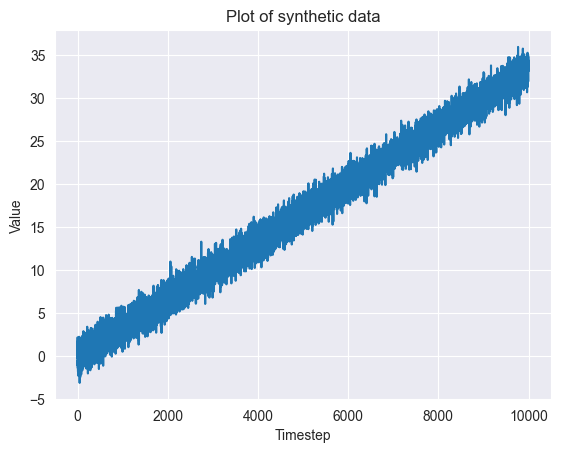

In [3]:
data = jnp.sin(jnp.arange(0, points)) * jnp.cos(jnp.arange(0, points)) + jnp.arange(0, points) * 1/300 + jax.random.normal(key=key, shape=(points,))
sns.lineplot(data)
plt.title("Plot of synthetic data")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.show();

In [4]:
from lstm import LSTM
from pprint import pprint

In [5]:
params = LSTM.init_params(seed=42, input_dim=1, hidden_dim=1, output_dim=1)


In [6]:
zero_arr = jnp.array([[0.]])

In [7]:
params.wf

Array([[-2.169826  ,  0.46480057]], dtype=float32)

In [8]:
jnp.concatenate([zero_arr, zero_arr], axis=1)

Array([[0., 0.]], dtype=float32)

In [9]:
LSTM.f_cur(params, zero_arr, zero_arr)

Array([[0.45395288]], dtype=float32)

In [10]:
LSTM.i_cur(params, zero_arr, zero_arr)

(Array([[0.45395288]], dtype=float32), Array([[-0.18263935]], dtype=float32))

In [11]:
LSTM.c_cur(params, zero_arr, zero_arr, zero_arr)

Array([[-0.08290966]], dtype=float32)

In [12]:
LSTM.h_cur(params, zero_arr, zero_arr, zero_arr)

Array([[-0.03755108]], dtype=float32)

In [13]:
LSTM.forward(params, zero_arr, zero_arr, zero_arr, zero_arr)

(Array([[-0.08290966]], dtype=float32),
 Array([[-0.]], dtype=float32),
 Array([[-0.03755108]], dtype=float32))

In [14]:
print(jnp.array([[0.]])[:,0])

[0.]


In [15]:
LSTM.forward_full(params, jnp.array([[0.]]))

Array([[[0.00693613]]], dtype=float32)

In [16]:
def preprocess_ts(
    x: jnp.ndarray, 
    y: jnp.ndarray,
    timestep: int
) -> tuple[jnp.ndarray, jnp.ndarray]:
    x_window = np.lib.stride_tricks.sliding_window_view(
        x, window_shape=(timestep,), axis=0
    )
    y_window = np.lib.stride_tricks.sliding_window_view(
        y, window_shape=(timestep,), axis=0
    )

    x_window = jnp.expand_dims(jnp.array(x_window), axis=1)
    y_window = jnp.expand_dims(jnp.array(y_window), axis=2)
    return jnp.array(x_window), jnp.array(y_window)

In [17]:
x_window, y_window = preprocess_ts(np.arange(points).astype(np.float32), data, 5)

Each input will be a 2D array, with each 1D array inside it containing the time series for one variate.

In [18]:
x_window

Array([[[0.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 4.000e+00]],

       [[1.000e+00, 2.000e+00, 3.000e+00, 4.000e+00, 5.000e+00]],

       [[2.000e+00, 3.000e+00, 4.000e+00, 5.000e+00, 6.000e+00]],

       ...,

       [[9.993e+03, 9.994e+03, 9.995e+03, 9.996e+03, 9.997e+03]],

       [[9.994e+03, 9.995e+03, 9.996e+03, 9.997e+03, 9.998e+03]],

       [[9.995e+03, 9.996e+03, 9.997e+03, 9.998e+03, 9.999e+03]]],      dtype=float32)

In [19]:
y_window

Array([[[-0.25528347],
        [ 2.2098098 ],
        [-1.075549  ],
        [-0.6162643 ],
        [-0.47484183]],

       [[ 2.2098098 ],
        [-1.075549  ],
        [-0.6162643 ],
        [-0.47484183],
        [-0.5634904 ]],

       [[-1.075549  ],
        [-0.6162643 ],
        [-0.47484183],
        [-0.5634904 ],
        [-1.3878875 ]],

       ...,

       [[31.921553  ],
        [34.832302  ],
        [33.669502  ],
        [34.03183   ],
        [34.385635  ]],

       [[34.832302  ],
        [33.669502  ],
        [34.03183   ],
        [34.385635  ],
        [33.160385  ]],

       [[33.669502  ],
        [34.03183   ],
        [34.385635  ],
        [33.160385  ],
        [33.882206  ]]], dtype=float32)

In [20]:
params = LSTM.init_params(seed=42, input_dim=1, hidden_dim=10, output_dim=1)

In [21]:
forward_full_batch = jax.vmap(LSTM.forward_full, in_axes=(None, 0))

In [22]:
x_window[0:2]

Array([[[0., 1., 2., 3., 4.]],

       [[1., 2., 3., 4., 5.]]], dtype=float32)

In [23]:
out = LSTM.forward_batch(params, x_window[0:2])
out

Array([[[1.2368988],
        [2.0593126],
        [2.3274755],
        [2.2402394],
        [2.1290812]],

       [[1.6146609],
        [2.186683 ],
        [2.180825 ],
        [2.1135547],
        [2.098273 ]]], dtype=float32)

In [24]:
true = y_window[0:2]
true

Array([[[-0.25528347],
        [ 2.2098098 ],
        [-1.075549  ],
        [-0.6162643 ],
        [-0.47484183]],

       [[ 2.2098098 ],
        [-1.075549  ],
        [-0.6162643 ],
        [-0.47484183],
        [-0.5634904 ]]], dtype=float32)

In [25]:
jnp.mean((out - true) ** 2)

Array(6.137471, dtype=float32)

In [26]:
num_epochs = 10
batch_size = 10
num_batches = x_window.shape[0] // batch_size
learning_rate = 1e-5

In [27]:
params.wo.shape

(10, 11)

In [28]:
LSTM.mse(params, x_window[0:2], y_window[0:2])

Array(6.137471, dtype=float32)

In [29]:
mse_grad = jax.jacobian(LSTM.mse, argnums=(0,), allow_int=True)
mse_grad(params, x_window[0:2], y_window[0:2])[0].wo.shape

(10, 11)

In [30]:
optimiser = optax.adam(learning_rate=learning_rate)
opt_state = optimiser.init(params)

In [31]:
opt_state

(ScaleByAdamState(count=Array(0, dtype=int32), mu=LSTMParams(key=Array([0, 0], dtype=uint32), input_dim=Array(0, dtype=int32, weak_type=True), hidden_dim=Array(0, dtype=int32, weak_type=True), output_dim=Array(0, dtype=int32, weak_type=True), wf=Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32), bf=Array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], dtype=float32), wi=Array([[0., 0., 0., 0., 0., 0., 0., 

In [32]:
for epoch in range(num_epochs):
    print(f"Epoch: {epoch + 1}")

    for i in range(num_batches):
        x_batch = x_window[i * batch_size : (i + 1) * batch_size]
        y_batch = y_window[i * batch_size : (i + 1) * batch_size]
        
        cur_grad = LSTM.backward(params, x_batch, y_batch)[0]
        updates, opt_state = optimiser.update(cur_grad, opt_state, params)
        new_params = optax.apply_updates(params, updates)

Epoch: 1
Epoch: 2
Epoch: 3
